## Generate Training and Test Data

500

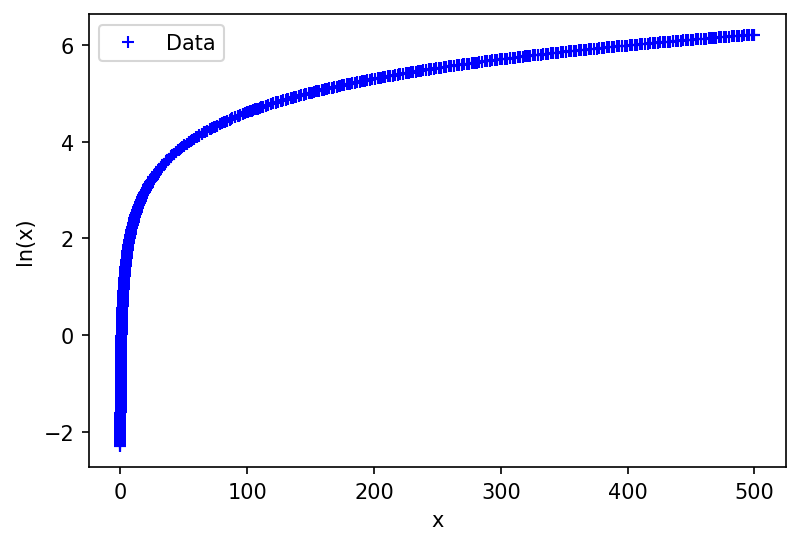

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import math

trainDataNum = 500
minXTrain = 0.1        # 0 is ill-defined, let's not go there 
maxXTrain = 500         # 5 is enough, we're just trying to see how neural networks work

# Lets try more equally distributed samples
datXequdist = np.linspace(minXTrain,maxXTrain,math.floor(trainDataNum/2))
datYequdist = np.exp(np.linspace(np.log(minXTrain),np.log(maxXTrain),math.floor(trainDataNum/2)))
xTrain = np.concatenate((datXequdist, datYequdist))
display(len(xTrain))


#xTrain = rnd.uniform(minXTrain,maxXTrain,trainDataNum)
yTrain = np.log(xTrain)

plt.figure(dpi=150)
plt.plot(xTrain,yTrain,'b+',label = "Data")
plt.xlabel("x")
plt.ylabel("ln(x)")
plt.legend()
plt.show()

In [2]:
t_x   = list(xTrain)
t_lnx = list(yTrain)
t_x_tensor   = torch.tensor(t_x).unsqueeze(1)
t_lnx_tensor = torch.tensor(t_lnx).unsqueeze(1)

## training and validation set

In [3]:
n_samples  = t_x_tensor.shape[0]
n_val      = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val] # training set indices
val_indices   = shuffled_indices[-n_val:] # validation set indices

t_x_train   = t_x_tensor[train_indices]
t_lnx_train = t_lnx_tensor[train_indices]

t_x_val   = t_x_tensor[val_indices]
t_lnx_val = t_lnx_tensor[val_indices]

Burak: we shouldn't need normalization

In [4]:
#t_un_train = 0.1 * t_u_train
#t_un_val = 0.1 * t_u_val

t_lnx_norm_train = t_lnx_train
t_lnx_norm_val = t_lnx_val
t_x_norm_train = t_x_train
t_x_norm_val = t_x_val

In [5]:
# Type Casting
t_lnx_norm_train = t_lnx_norm_train.type(torch.FloatTensor)
t_lnx_norm_val = t_lnx_norm_val.type(torch.FloatTensor)
t_x_norm_train = t_x_norm_train.type(torch.FloatTensor)
t_x_norm_val = t_x_norm_val.type(torch.FloatTensor)

In [7]:
import torch.nn as nn

model definition (initializes parameters to random values)

In [8]:
linear_model = nn.Linear(1,1,True)
# linear model accepts 3 : input size, output size and bias defaults to True

In [9]:
linear_model.weight

Parameter containing:
tensor([[-0.5898]], requires_grad=True)

we'll check if this changes below to validate the training_loop

train loop definition

In [10]:
def training_loop(n_epochs, batch_size, optimizer, model, loss_fn, t_lnx_train, t_lnx_val, t_x_train, t_x_val, output_freq):
    for epoch in range(1, n_epochs + 1):
        
        # Shuffle training dataset before each epoch
        n_samples  = t_x_train.shape[0]
        shuffled_indices = torch.randperm(n_samples)
        t_x_train   = t_x_train[shuffled_indices]
        t_lnx_train = t_lnx_train[shuffled_indices]
              
        
        
        for i in range(0, n_samples, batch_size):
            optimizer.zero_grad() # what is it for? 

            indices = range(i,i+batch_size)
            batch_x, batch_y = t_x_train[indices], t_lnx_train[indices]

            t_p_train  = model(batch_x) # predicted output
            loss_train = loss_fn(t_p_train, batch_y)
        
            loss_train.backward()
            optimizer.step()
            
            
        t_p_val = model(t_x_val)
        loss_val = loss_fn(t_p_val, t_lnx_val)
        if epoch ==1 or epoch % output_freq == 0:
            #print("predicted t_p_train : ", t_p_train)
            print("Epoch: ", epoch, " Training loss: ", loss_train.item(), " Val loss:", loss_val.item())

optimizer and loss fcn (Adam automatically scales learning rate as the training goes along, better for stability)

In [11]:
optimizer   = optim.Adam(linear_model.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    batch_size  = 200,
    optimizer   = optimizer,
    model       = linear_model,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  19059.267578125  Val loss: 49.380706787109375
Epoch:  1000  Training loss:  2.5838942527770996  Val loss: 11.403558731079102
Epoch:  2000  Training loss:  2.445267677307129  Val loss: 8.791250228881836
Epoch:  3000  Training loss:  1.9378162622451782  Val loss: 8.687912940979004
Epoch:  4000  Training loss:  2.383845090866089  Val loss: 8.690521240234375
Epoch:  5000  Training loss:  2.600252389907837  Val loss: 8.696887969970703
Epoch:  6000  Training loss:  2.3924849033355713  Val loss: 8.67772388458252
Epoch:  7000  Training loss:  2.242950201034546  Val loss: 8.68371868133545
Epoch:  8000  Training loss:  2.2506978511810303  Val loss: 8.677903175354004
Epoch:  9000  Training loss:  2.1124091148376465  Val loss: 8.685019493103027
Epoch:  10000  Training loss:  2.23160457611084  Val loss: 8.698531150817871


In [12]:
linear_model.weight

Parameter containing:
tensor([[0.0118]], requires_grad=True)

the parameter changed, the network got trained somehow.

but the "line of best fit" can't really fit an ln() function, so this linear model fails miserably

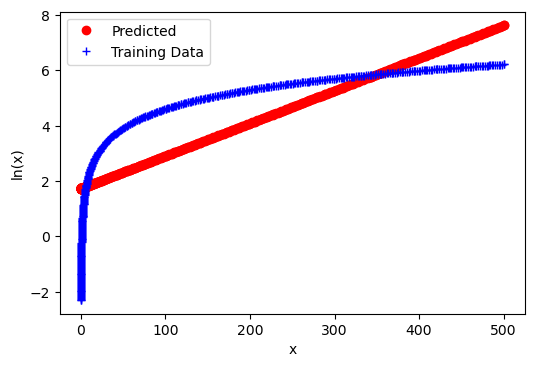

In [13]:
plt.figure(dpi=100)


t_x_tensor_float = t_x_tensor.type(torch.FloatTensor)
t_lnx_tensor_float = t_lnx_tensor.type(torch.FloatTensor)
x_predicted = linear_model(t_x_tensor_float)

plt.plot(t_x_tensor_float,x_predicted.detach().numpy(),'ro', label = "Predicted")
plt.plot(t_x_tensor_float,t_lnx_tensor_float,'b+',label = "Training Data")
plt.xlabel("x")
plt.ylabel("ln(x)")
plt.legend()
plt.show()

### Nonlinear model, but not deep, and not a lot of parameters

In [14]:
nonlin = nn.Sequential(
            nn.Linear(1,3),
            nn.ReLU(),
            nn.Linear(3,1))
nonlin

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

In [15]:
optimizer   = optim.Adam(nonlin.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    batch_size  = 200,
    optimizer   = optimizer,
    model       = nonlin,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  91.85903930664062  Val loss: 13.298264503479004
Epoch:  1000  Training loss:  0.45105114579200745  Val loss: 10.372632026672363
Epoch:  2000  Training loss:  0.2949868142604828  Val loss: 12.190264701843262
Epoch:  3000  Training loss:  0.25423088669776917  Val loss: 11.890484809875488
Epoch:  4000  Training loss:  0.2521008551120758  Val loss: 11.64626693725586
Epoch:  5000  Training loss:  0.2849249243736267  Val loss: 11.485509872436523
Epoch:  6000  Training loss:  0.25689470767974854  Val loss: 11.329024314880371
Epoch:  7000  Training loss:  0.30525320768356323  Val loss: 11.25190544128418
Epoch:  8000  Training loss:  0.2452772855758667  Val loss: 11.708745002746582
Epoch:  9000  Training loss:  0.15452934801578522  Val loss: 10.469963073730469
Epoch:  10000  Training loss:  0.13116014003753662  Val loss: 9.672370910644531


### Nonlinear and deeper model, still not many parameters


In [16]:
nonlin_deep = nn.Sequential(
            nn.Linear(1,2),
            nn.ReLU(),
            nn.Linear(2,3),
            nn.ReLU(),
            nn.Linear(3,2),
            nn.ReLU(),
            nn.Linear(2,1)
)

nonlin_deep

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
)

In [17]:
optimizer   = optim.Adam(nonlin_deep.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    batch_size  = 200,
    optimizer   = optimizer,
    model       = nonlin_deep,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  69.72254943847656  Val loss: 15.854239463806152
Epoch:  1000  Training loss:  0.08796772360801697  Val loss: 5.883852481842041
Epoch:  2000  Training loss:  0.06356872618198395  Val loss: 7.264001369476318
Epoch:  3000  Training loss:  0.05551804229617119  Val loss: 7.234134674072266
Epoch:  4000  Training loss:  0.07076223194599152  Val loss: 7.274300575256348
Epoch:  5000  Training loss:  0.06545348465442657  Val loss: 7.252626419067383
Epoch:  6000  Training loss:  0.06912409514188766  Val loss: 7.2860236167907715
Epoch:  7000  Training loss:  0.060286954045295715  Val loss: 7.225424289703369
Epoch:  8000  Training loss:  0.05957780405879021  Val loss: 7.300585746765137
Epoch:  9000  Training loss:  0.062445517629384995  Val loss: 7.3176398277282715
Epoch:  10000  Training loss:  0.06635961681604385  Val loss: 7.339972019195557


### Nonlinear, deep and large model

In [18]:
nonlin_deep_large = nn.Sequential(
            nn.Linear(1,10),
            nn.ReLU(),
            nn.Linear(10,20),
            nn.ReLU(),
            nn.Linear(20,40),
            nn.ReLU(),
            nn.Linear(40,30),
            nn.ReLU(),
            nn.Linear(30,10),
            nn.ReLU(),
            nn.Linear(10,1)
)

nonlin_deep_large

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=40, bias=True)
  (5): ReLU()
  (6): Linear(in_features=40, out_features=30, bias=True)
  (7): ReLU()
  (8): Linear(in_features=30, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=1, bias=True)
)

In [19]:
optimizer   = optim.Adam(nonlin_deep_large.parameters(), lr=1e-2)
loss_fcn    = nn.MSELoss()

training_loop(
    n_epochs    = 10000,
    batch_size  = 200,
    optimizer   = optimizer,
    model       = nonlin_deep_large,
    loss_fn     = loss_fcn,
    t_lnx_train = t_lnx_norm_train,
    t_lnx_val   = t_lnx_norm_val,
    t_x_train   = t_x_norm_train,
    t_x_val     = t_lnx_norm_val,
    output_freq = 1000
)

Epoch:  1  Training loss:  3.713686466217041  Val loss: 15.228462219238281
Epoch:  1000  Training loss:  0.004852317739278078  Val loss: 15.521905899047852
Epoch:  2000  Training loss:  0.000561554217711091  Val loss: 13.57058334350586
Epoch:  3000  Training loss:  8.322325447807088e-05  Val loss: 20.164710998535156
Epoch:  4000  Training loss:  0.00011271434050286189  Val loss: 20.334556579589844
Epoch:  5000  Training loss:  7.714364619459957e-05  Val loss: 20.122112274169922
Epoch:  6000  Training loss:  0.0008470745524391532  Val loss: 20.277978897094727
Epoch:  7000  Training loss:  0.00011582076695049182  Val loss: 21.404685974121094
Epoch:  8000  Training loss:  0.0001515801268396899  Val loss: 21.536182403564453
Epoch:  9000  Training loss:  0.00022086653916630894  Val loss: 21.47793960571289
Epoch:  10000  Training loss:  0.001133042387664318  Val loss: 21.335538864135742


this model didn't overfit the train set since we didn't give it a lot of data, but see how validation loss is still very high. 

Overall, the output will look like ln(), but we'll see bad examples 

### Comparing all models

let's just check validation performance

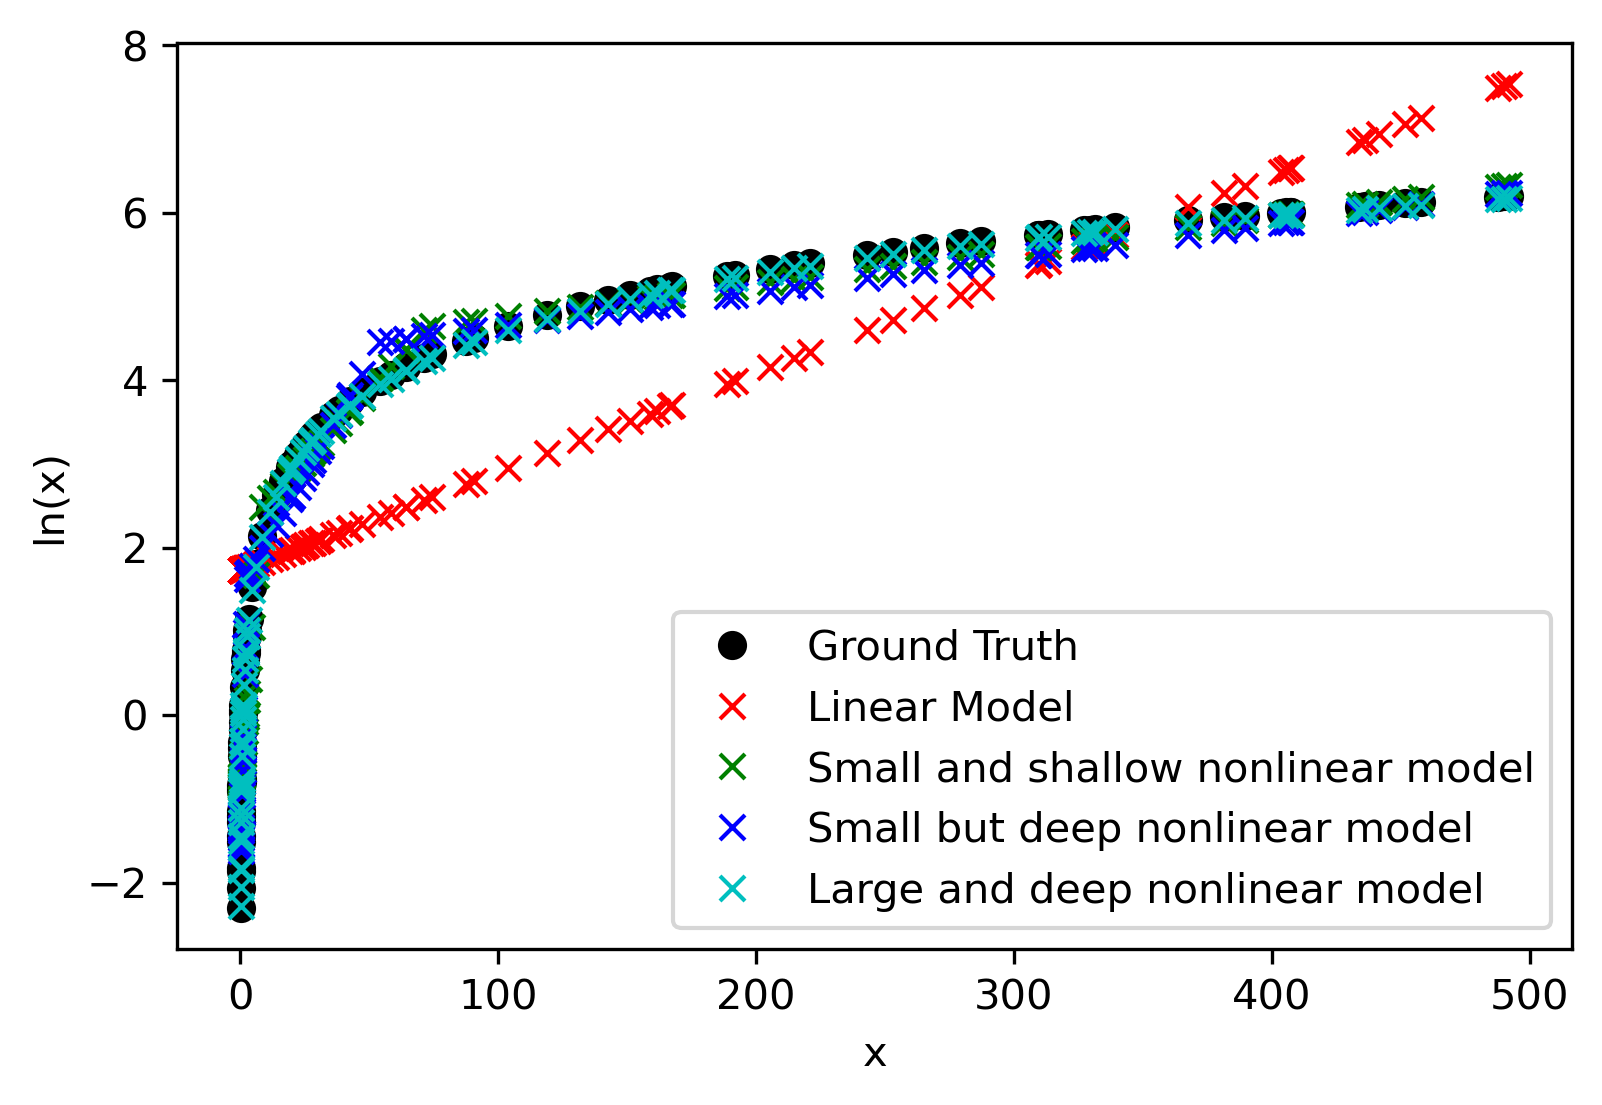

In [20]:
from matplotlib import pyplot as plt

t_range = torch.arange(20.,40.).unsqueeze(1)

fig = plt.figure(dpi=300)

plt.xlabel("x")
plt.ylabel("ln(x)")
plt.plot(t_x_norm_val.numpy(), t_lnx_norm_val.numpy(),'ko', label = "Ground Truth")
plt.plot(t_x_norm_val.numpy(), linear_model(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(),'rx',label = "Linear Model")
plt.plot(t_x_norm_val.numpy(), nonlin(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(), 'gx',label = "Small and shallow nonlinear model")
plt.plot(t_x_norm_val.numpy(), nonlin_deep(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(), 'bx',label = "Small but deep nonlinear model")
plt.plot(t_x_norm_val.numpy(), nonlin_deep_large(t_x_norm_val.type(torch.FloatTensor)).detach().numpy(), 'cx',label = "Large and deep nonlinear model")
plt.legend()